## 读取数据
reviews.txt - 含有 25000 条影评  
labels.txt - 针对 reviews.txt 中的影评的 positive/negative 情感标签

In [1]:
import pandas as pd
raw_data = pd.read_table("reviews.txt", header=None, names=["reviews"])
raw_data["labels"] = pd.read_table("labels.txt", header=None)

## 数据探索

In [2]:
# 打印前三行
raw_data.head(10)

,reviews,labels
0,bromwell high is a cartoon comedy . it ran at ...,positive
1,story of a man who has unnatural feelings for ...,negative
2,homelessness or houselessness as george carli...,positive
3,airport starts as a brand new luxury pla...,negative
4,brilliant over acting by lesley ann warren . ...,positive
5,this film lacked something i couldn t put my ...,negative
6,this is easily the most underrated film inn th...,positive
7,sorry everyone i know this is supposed to b...,negative
8,this is not the typical mel brooks film . it w...,positive
9,when i was little my parents took me along to ...,negative


In [3]:
# 查看数据形状
raw_data.shape

(25000, 2)

In [4]:
# 查看正负例比例
raw_data.groupby("labels").count()

,reviews
labels,
negative,12500
positive,12500


## 数据预处理
1. 分词
2. 标签转换
3. 统计词频

In [5]:
# 分词
data = raw_data["reviews"].apply(lambda x: x.split()).to_frame()

In [6]:
# 标签转换
data["labels"] = raw_data["labels"].apply(lambda x: 1 if x == "positive" else 0)

In [7]:
# 打印前五行
data.head() 

,reviews,labels
0,"[bromwell, high, is, a, cartoon, comedy, ., it...",1
1,"[story, of, a, man, who, has, unnatural, feeli...",0
2,"[homelessness, or, houselessness, as, george, ...",1
3,"[airport, starts, as, a, brand, new, luxury, p...",0
4,"[brilliant, over, acting, by, lesley, ann, war...",1


In [8]:
# 统计词频
from collections import Counter

positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

for _, row in data.iterrows():  # 使用iterrows方法可以高效遍历df
    review, label = row
    for word in review:
        total_counts[word] += 1
        if label:
            positive_counts[word] += 1
        else:
            negative_counts[word] += 1

In [9]:
# 预览正面词
positive_counts.most_common(10)

[('the', 173324),
 ('.', 159654),
 ('and', 89722),
 ('a', 83688),
 ('of', 76855),
 ('to', 66746),
 ('is', 57245),
 ('in', 50215),
 ('br', 49235),
 ('it', 48025)]

In [10]:
# 预览负面词
negative_counts.most_common(10)

[('.', 167538),
 ('the', 163389),
 ('a', 79321),
 ('and', 74385),
 ('of', 69009),
 ('to', 68974),
 ('br', 52637),
 ('is', 50083),
 ('it', 48327),
 ('i', 46880)]

In [11]:
# 预览所有词
total_counts.most_common(10)

[('the', 336713),
 ('.', 327192),
 ('and', 164107),
 ('a', 163009),
 ('of', 145864),
 ('to', 135720),
 ('is', 107328),
 ('br', 101872),
 ('it', 96352),
 ('in', 93968)]

## 特征建立
1. 建立单词与数字的对应关系
2. 训练one-hot向量
3. 正负词频比

In [12]:
# 建立单词与数字的对应关系
word2index = Counter({word: i for i,word in enumerate(sorted(total_counts.keys()))})

In [13]:
# 预览word2index
word2index.most_common()[-1:-6:-1]

[('.', 0), ('a', 1), ('aa', 2), ('aaa', 3), ('aaaaaaah', 4)]

In [14]:
# 训练one-hot向量

import numpy as np
from sklearn import preprocessing

k = len(word2index)
lb = preprocessing.LabelBinarizer()
lb.fit(range(k))

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [15]:
# 测试one-hot向量
lb.transform(np.array([0, 2, 1]))

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [16]:
# 统计正负词频比
pos_neg_ratio = Counter({word:  (positive_counts[word] + 1) / (negative_counts[word] + 1) for word in total_counts})

In [17]:
# 预览pos_neg_ratio
pos_neg_ratio.most_common(5)

[('edie', 110.0),
 ('antwone', 89.0),
 ('din', 83.0),
 ('gunga', 67.0),
 ('goldsworthy', 66.0)]

In [18]:
# 预览pos_neg_ratio
pos_neg_ratio.most_common()[-1:-5:-1]

[('boll', 0.013888888888888888),
 ('uwe', 0.0196078431372549),
 ('slater', 0.02),
 ('hobgoblins', 0.021739130434782608)]

## 特征分析
1. 词频分布
2. pos_neg_ratio分布

In [19]:
import matplotlib.pyplot as plt

In [20]:
# 词频分布描述
total_counts_series = pd.Series(sorted(total_counts.values(), reverse=True))
total_counts_series.describe()

count     74073.000000
mean         85.690981
std        2372.293271
min           1.000000
25%           1.000000
50%           3.000000
75%          11.000000
max      336713.000000
dtype: float64

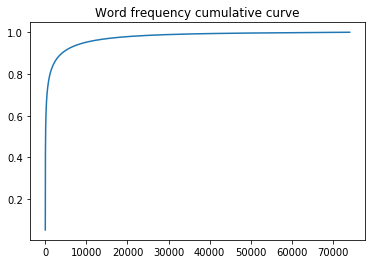

In [21]:
# 词频分布累积曲线
(total_counts_series.cumsum() / total_counts_series.sum()).plot(title="Word frequency cumulative curve")
plt.show()

In [22]:
# pos_neg_ratio描述
pos_neg_ratio_series = pd.Series(sorted(pos_neg_ratio.values(), reverse=True))
pos_neg_ratio_series.describe()

count    74073.000000
mean         1.571463
std          2.029624
min          0.013889
25%          0.500000
50%          1.000000
75%          2.000000
max        110.000000
dtype: float64

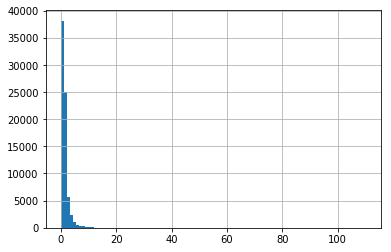

In [23]:
pos_neg_ratio_series.hist(bins = 100)
plt.show()

## 过滤噪声
1. 标准化
2. 低频词
3. 中立词

In [24]:
# 标准化，转为对数
pos_neg_ratio_log = {word: np.log(ratio) for word, ratio in pos_neg_ratio.items()}

In [25]:
# pos_neg_ratio描述
pos_neg_ratio_log_series = pd.Series(sorted(pos_neg_ratio_log.values(), reverse=True))
pos_neg_ratio_log_series.describe()

count    74073.000000
mean         0.061498
std          0.873143
min         -4.276666
25%         -0.693147
50%          0.000000
75%          0.693147
max          4.700480
dtype: float64

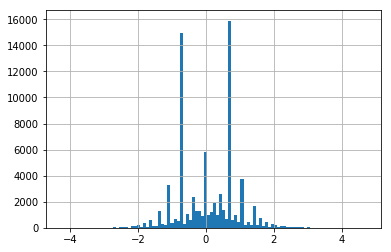

In [26]:
# 分布图
pos_neg_ratio_log_series.hist(bins = 100)
plt.show()

In [27]:
# 过滤低频词
least_word_freq = 100

In [28]:
# 过滤中立词
least_ratio = 0.1

In [29]:
# 重新生成pos_neg_ratio_log
pos_neg_ratio_log_new = {}
for word, ratio in pos_neg_ratio.items():
    if total_counts[word] > least_word_freq:
        ratio = np.log(ratio) 
        if abs(ratio) > least_ratio:
            pos_neg_ratio_log_new[word] = ratio

pos_neg_ratio_log_series_new = pd.Series(sorted(pos_neg_ratio_log_new.values(), reverse=True))

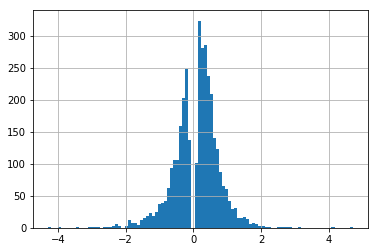

In [30]:
# 分布图
pos_neg_ratio_log_series_new.hist(bins = 100)
plt.show()

## 模型设计 
1. 输入层：一维向量，向量长度为n_word
2. 隐藏层：隐藏层，hidden_nodes * n_word，输出长度为hidden_nodes的一维向量
3. 输出：0或者1，实际是介于0和1之间的小数

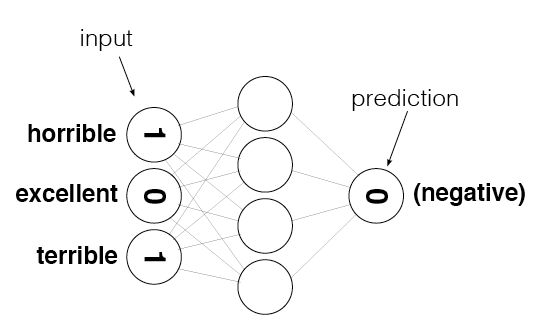

In [31]:
from IPython.display import Image
review = "This was a horrible, terrible movie."
Image(filename='sentiment_network.png')

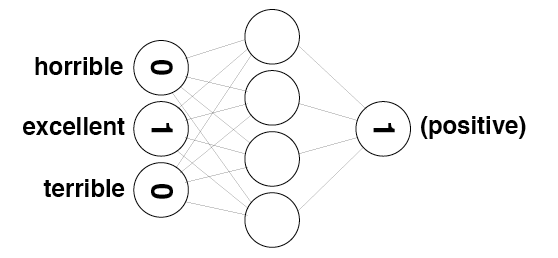

In [32]:
review = "The movie was excellent"
Image(filename='sentiment_network_pos.png')

## 模型建立 

In [33]:
# 清空内存
%reset-sf

In [34]:
from keras.preprocessing.text import Tokenizer
# 打开文本,读取文本数据
f = open("reviews.txt")
reviews = f.readlines()
f.close()
# 建立Tokenizer，并训练文本数据
tk = Tokenizer()
tk.fit_on_texts(reviews)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [44]:
from collections import Counter
# 统计词频
p_counts = Counter()
n_counts = Counter()
g = open("labels.txt")
labels = g.readlines()
g.close()

for review, label in zip(reviews, labels):
    for word in review.split():
        if label == "positive\n":
            p_counts[word] += 1
        else:
            n_counts[word] += 1

In [45]:
import numpy as np
# 低频词阈值
least_word_freq = 100
# 中立词阈值
least_ratio = 0.1
# 统计正负词频比的对数，并过滤低频词
pn_ratio_log = {word: np.log((p_counts[word] + 1) / (n_counts[word] + 1)) for word, cnt in tk.word_counts.items() if cnt > least_word_freq}
# 过滤中立词
pn_ratio_log = {word: ratio for word, ratio in pn_ratio_log.items() if abs(ratio) > least_ratio}
# 去除tk中的停用词，不知道为什么Keras自动建立的word_index是从1开始的
tk.word_index = {word: i  for i, word in enumerate(pn_ratio_log)}

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [49]:
# 输入维度，注意+1
vocab_size = len(tk.word_index) + 1
# 隐藏层节点数
hidden_nodes = 10

In [50]:
# 建立模型
model = Sequential()
# 添加隐藏层
model.add(Dense(hidden_nodes, activation=None, init='uniform', input_shape=(vocab_size,)))
# 添加输出层
model.add(Dense(1, activation='sigmoid', init='uniform', input_shape=(hidden_nodes,)))
# 编译模型
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation=None, input_shape=(3524,), kernel_initializer="uniform")`
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", input_shape=(10,), kernel_initializer="uniform")`
  


In [57]:
# 生成X
X = tk.texts_to_matrix(reviews)
X.shape

(25000, 3524)

In [59]:
# 生成Y
Y = np.array([1 if label == "positive\n" else 0 for label in labels])
Y.shape

(25000,)

In [60]:
# 训练模型
model.fit(X, Y, nb_epoch=5, batch_size=10)

C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/5
25000/25000 [==============================] - 7s 297us/step - loss: 0.3284 - acc: 0.8672
Epoch 2/5
25000/25000 [==============================] - 8s 302us/step - loss: 0.2472 - acc: 0.9021
Epoch 3/5
25000/25000 [==============================] - 7s 298us/step - loss: 0.2296 - acc: 0.9094 1s - los
Epoch 4/5
25000/25000 [==============================] - 7s 280us/step - loss: 0.2218 - acc: 0.9129
Epoch 5/5
25000/25000 [==============================] - 8s 300us/step - loss: 0.2151 - acc: 0.9149


In [61]:
model.predict(tk.texts_to_matrix(["this movie is totally a piece of shit, really terrible and awful\n"]))

array([[0.13178451]], dtype=float32)